<a href="https://colab.research.google.com/github/Divyesh0810/Sentiment-Analysis-of-product-based-reviews-using-transformers/blob/main/ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.stats import norm
from wordcloud import WordCloud,STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer as CVTZ
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

def set_seed(seed=31415):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

def RMSE(Y,YHAT):
    return np.sqrt(mean_squared_error(Y,YHAT))

plt.rc('figure',figsize=(20,11))

In [ ]:
stopwords = list(STOPWORDS)
nltk.download('stopwords')
nltk.download('wordnet')
stopWords_nltk = set(stopwords.words('english'))
sns.set_style('darkgrid')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


AttributeError: 'list' object has no attribute 'words'

In [ ]:
df= pd.read_csv("tripadvisor_hotel_reviews.csv")
print("df.columns: ",df.columns)

In [ ]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
import re
from typing import Union, List

class CleanText():
    def __init__(self, clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğüı'şöç0-9.\"',()]"):
        self.clean_pattern =clean_pattern
    def __call__(self, text: Union[str, list]) -> List[List[str]]:
        if isinstance(text, str):
            docs = [[text]]
        if isinstance(text, list):
            docs = text
        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]
        return text

def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [ ]:
df.Rating.value_counts()


Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64

<ipython-input-7-cf4404bf2dc9>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(words_per_review,fit=norm, kde=False)


<Axes: >

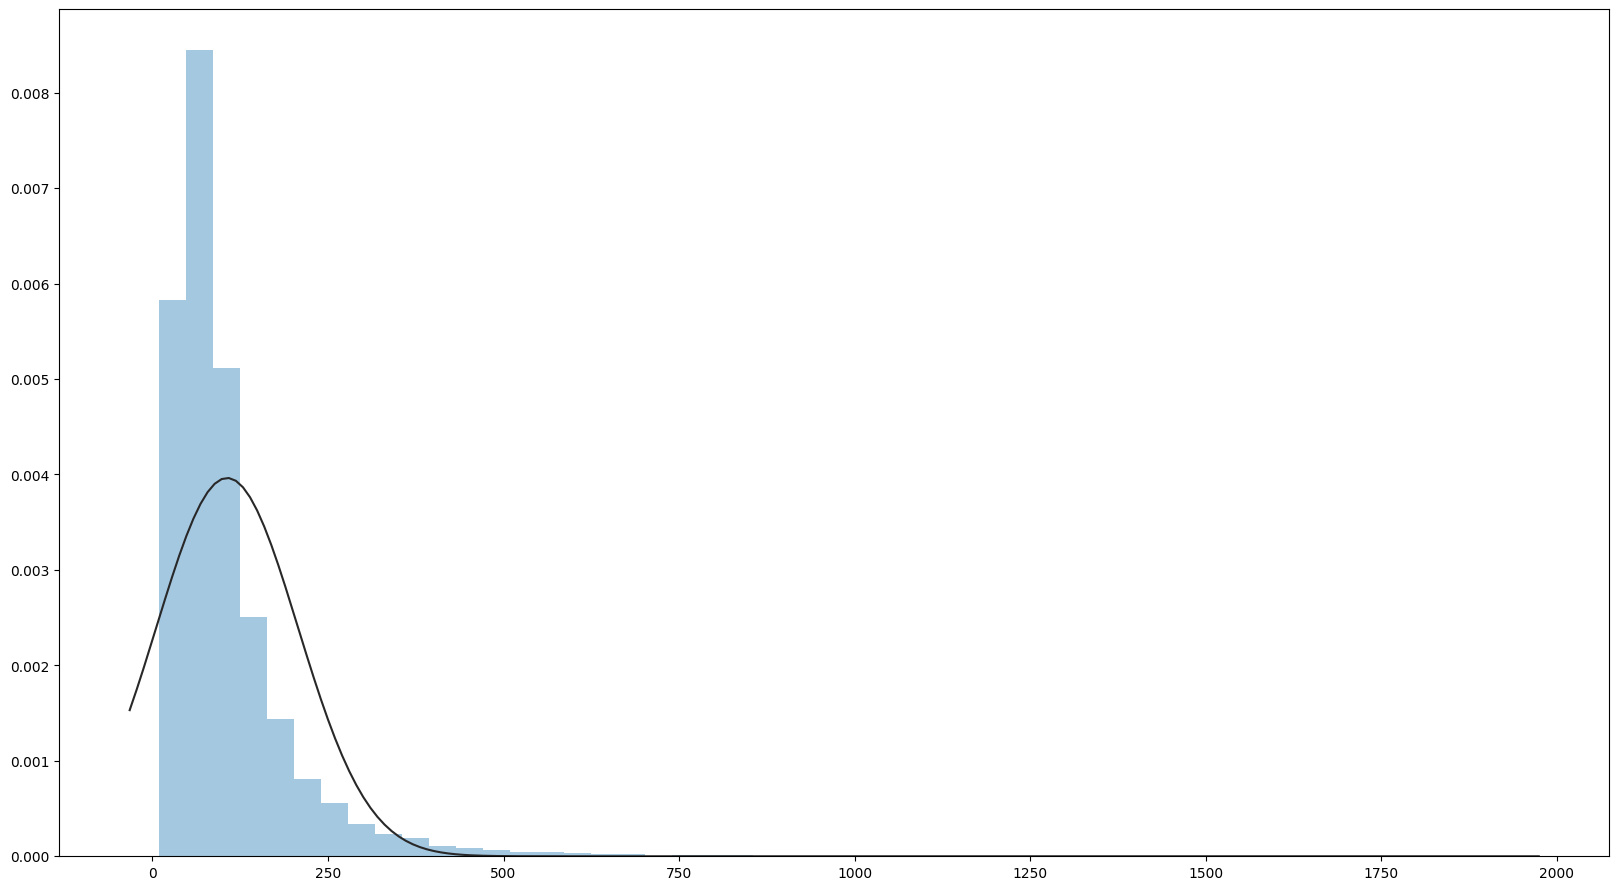

In [ ]:
words_per_review = [len(x.split(" ")) for x in df['Review']]
sns.distplot(words_per_review,fit=norm, kde=False)

In [ ]:
punc=string.punctuation
#stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def data_preprocessing(txt):
    #converting to lowercase
    txt=txt.lower()
    #Removing Punctuation
    txt="".join([x for x in txt if x not in punc])
    #Removing stopwords
    #txt=" ".join([word for word in str(txt).split() if word not in stop_words])
    #Stemming
    txt = " ".join([stemmer.stem(word) for word in txt.split()])
    #Lemmatization
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()])
    return txt
df['text'] = df['Review'].apply(data_preprocessing)

In [ ]:
df

,Review,Rating,text
0,nice hotel expensive parking got good deal sta...,4,nice hotel expens park got good deal stay hote...
1,ok nothing special charge diamond member hilto...,2,ok noth special charg diamond member hilton de...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room not 4 experi hotel monaco seattl goo...
3,"unique, great stay, wonderful time hotel monac...",5,uniqu great stay wonder time hotel monaco loca...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,best kept secret 3rd time stay charm not 5star...
20487,great location price view hotel great quick pl...,4,great locat price view hotel great quick place...
20488,"ok just looks nice modern outside, desk staff ...",2,ok just look nice modern outsid desk staff nt ...
20489,hotel theft ruined vacation hotel opened sept ...,1,hotel theft ruin vacat hotel open sept 17 2007...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=400, min_df=0.05, max_df=0.9)
tfidf = tfidfconverter.fit_transform(df['text']).toarray()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(tfidf,df['Rating'],test_size=0.2,random_state=42)

In [ ]:
#upsampling
from sklearn.utils import resample
from collections import Counter
print("Before Upsampling:-")
print(Counter(y_train))
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train,y_train)
print("After Upsampling:-")
print(Counter(y_train))

Before Upsampling:-
Counter({5: 7264, 4: 4787, 3: 1752, 2: 1460, 1: 1129})
After Upsampling:-
Counter({5: 7264, 4: 7264, 3: 7264, 2: 7264, 1: 7264})


In [ ]:
# training a Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(X_train, y_train)
y_pred_NB=mnb.predict(X_test)
print("Accuracy of Multinominal Naive Balyes:",accuracy_score(y_test, y_pred_NB))
print(classification_report(y_pred_NB,y_test))

Accuracy of Multinominal Naive Balyes: 0.544279092461576
              precision    recall  f1-score   support

           1       0.64      0.56      0.60       337
           2       0.40      0.23      0.29       588
           3       0.44      0.34      0.38       558
           4       0.44      0.52      0.48      1062
           5       0.65      0.75      0.70      1554

    accuracy                           0.54      4099
   macro avg       0.51      0.48      0.49      4099
weighted avg       0.53      0.54      0.53      4099



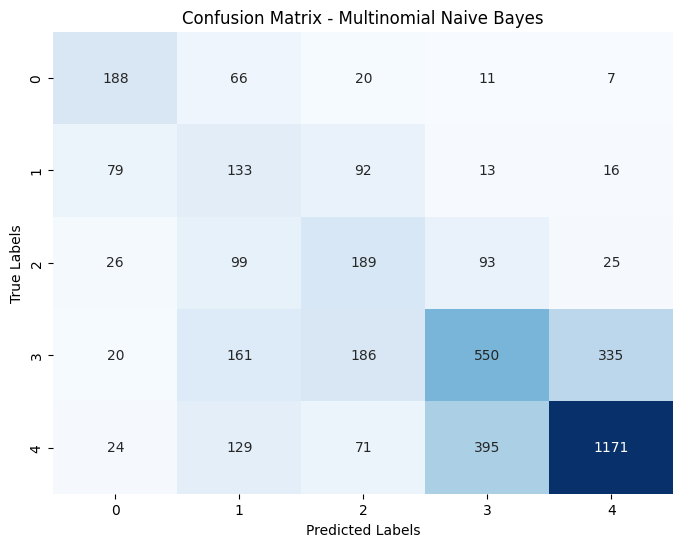

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_NB)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Multinomial Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
#logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(X_train, y_train)
y_pred_lr=logreg.predict(X_test)
print("Accuracy of Logistic Regression:",accuracy_score(y_test, y_pred_lr))
print(classification_report(y_pred_lr,y_test))

Accuracy of Logistic Regression: 0.5711149060746523
              precision    recall  f1-score   support

           1       0.69      0.54      0.60       375
           2       0.39      0.32      0.35       410
           3       0.45      0.34      0.39       579
           4       0.46      0.53      0.49      1081
           5       0.69      0.75      0.72      1654

    accuracy                           0.57      4099
   macro avg       0.54      0.49      0.51      4099
weighted avg       0.57      0.57      0.57      4099



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


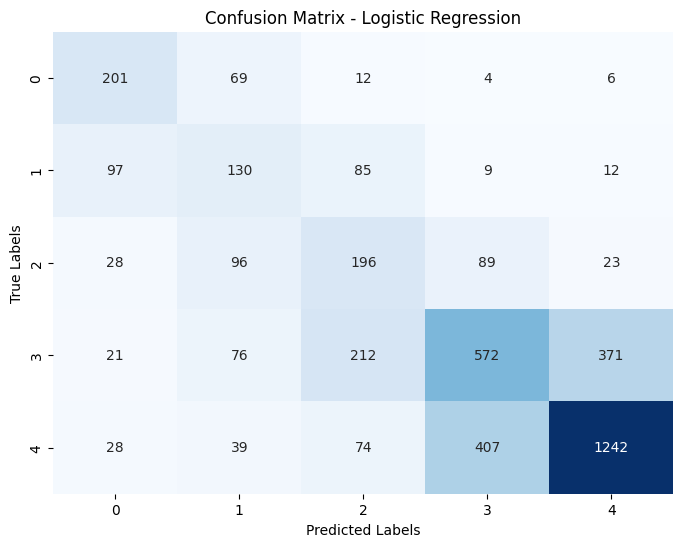

In [ ]:
cm = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
#decision tree
des_tree = DecisionTreeClassifier().fit(X_train, y_train)
y_pred_dt=des_tree.predict(X_test)
print("Accuracy of Decision Tree Classifier:",accuracy_score(y_test, y_pred_dt))
print(classification_report(y_pred_dt,y_test))

Accuracy of Decision Tree Classifier: 0.3861917540863625
              precision    recall  f1-score   support

           1       0.37      0.31      0.34       350
           2       0.22      0.16      0.18       459
           3       0.25      0.18      0.21       581
           4       0.33      0.36      0.34      1150
           5       0.49      0.57      0.53      1559

    accuracy                           0.39      4099
   macro avg       0.33      0.32      0.32      4099
weighted avg       0.37      0.39      0.38      4099



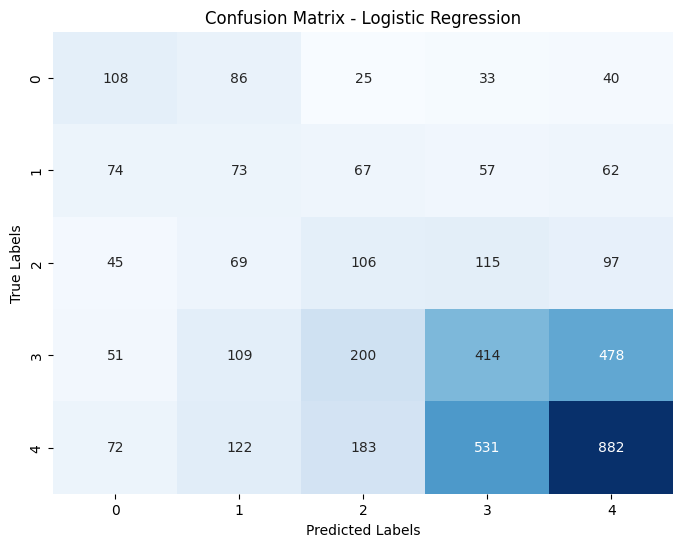

In [ ]:
cm = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
#random forest
rf = RandomForestClassifier().fit(X_train, y_train)
y_pred_rf=rf.predict(X_test)
print("Accuracy of Random Forest Classifier:",accuracy_score(y_test, y_pred_rf))
print(classification_report(y_pred_rf,y_test))

Accuracy of Random Forest Classifier: 0.5393998536228348
              precision    recall  f1-score   support

           1       0.60      0.53      0.56       328
           2       0.28      0.29      0.28       324
           3       0.22      0.31      0.26       317
           4       0.40      0.49      0.44      1041
           5       0.75      0.64      0.69      2089

    accuracy                           0.54      4099
   macro avg       0.45      0.45      0.45      4099
weighted avg       0.57      0.54      0.55      4099



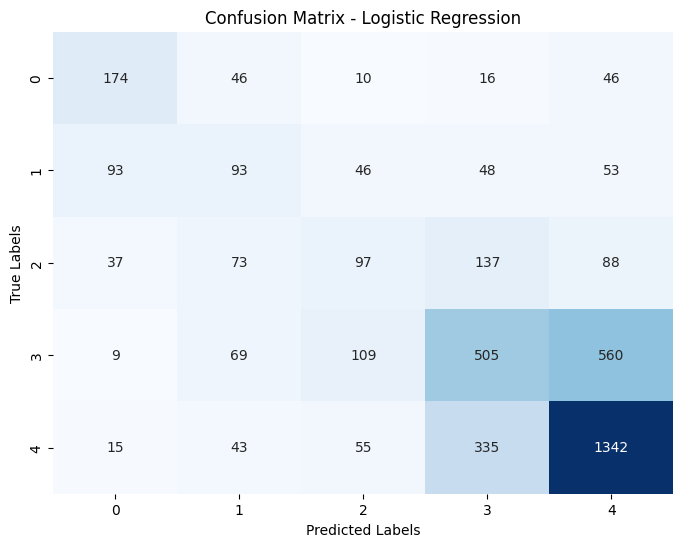

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
#K-NN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train)
y_pred_knn=knn.predict(X_test)
print("Accuracy of k-nearest neighbours Classifier:",accuracy_score(y_test, y_pred_knn))
print(classification_report(y_pred_knn,y_test))

Accuracy of k-nearest neighbours Classifier: 0.20761161258843622
              precision    recall  f1-score   support

           1       0.51      0.19      0.28       778
           2       0.37      0.12      0.18      1001
           3       0.40      0.14      0.20      1261
           4       0.26      0.34      0.30       969
           5       0.04      0.86      0.08        90

    accuracy                           0.21      4099
   macro avg       0.32      0.33      0.21      4099
weighted avg       0.37      0.21      0.23      4099



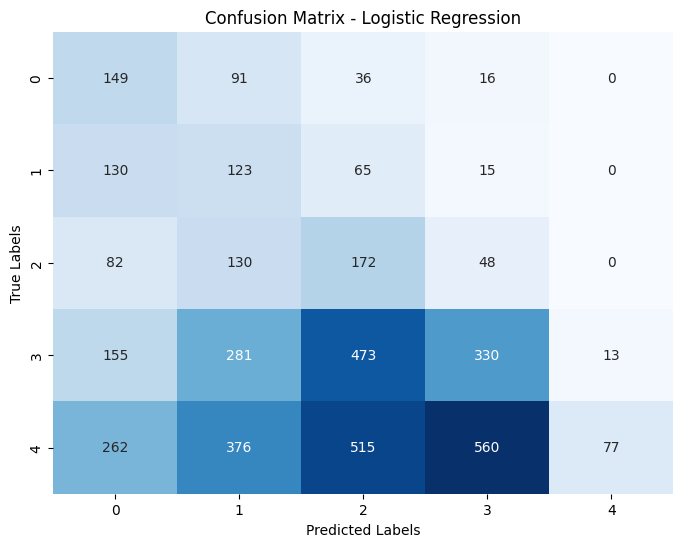

In [ ]:
cm = confusion_matrix(y_test, y_pred_knn)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
#SVM
from sklearn.svm import SVC
svc = SVC()
y_pred_svm=knn.predict(X_test)
print("Accuracy of SVM Classifier:",accuracy_score(y_test, y_pred_svm))
print(classification_report(y_pred_svm,y_test))

Accuracy of SVM Classifier: 0.20761161258843622
              precision    recall  f1-score   support

           1       0.51      0.19      0.28       778
           2       0.37      0.12      0.18      1001
           3       0.40      0.14      0.20      1261
           4       0.26      0.34      0.30       969
           5       0.04      0.86      0.08        90

    accuracy                           0.21      4099
   macro avg       0.32      0.33      0.21      4099
weighted avg       0.37      0.21      0.23      4099



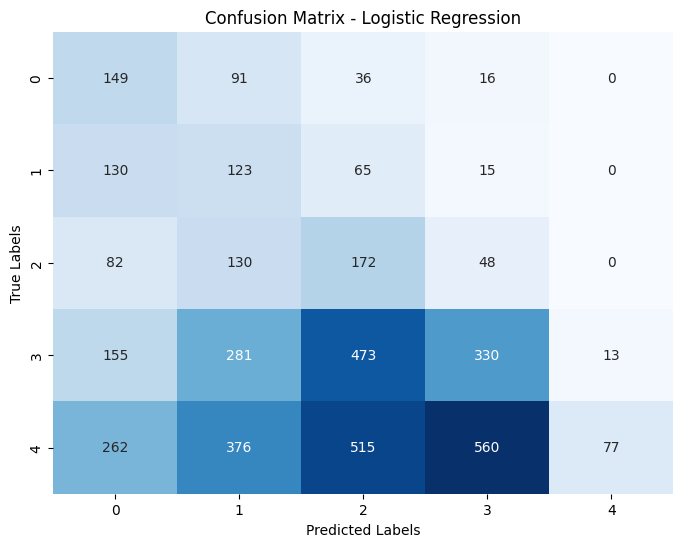

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
# Assuming you have a CSV file named 'tripadvisor_reviews.csv' with 'review' and 'label' columns
data = pd.read_csv('tripadvisor_hotel_reviews.csv')

# Split data into features and target
X = data['Review']
y = data['Rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust the max_features parameter as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the AdaBoost classifier
adaboost_clf = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train the classifier
adaboost_clf.fit(X_train_tfidf, y_train)

# Predictions on the test set
y_pred = adaboost_clf.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.548426445474506

Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.48      0.54       292
           2       0.34      0.37      0.35       333
           3       0.36      0.16      0.22       432
           4       0.47      0.40      0.43      1252
           5       0.63      0.79      0.70      1790

    accuracy                           0.55      4099
   macro avg       0.48      0.44      0.45      4099
weighted avg       0.53      0.55      0.53      4099



In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
# Assuming you have a CSV file named 'tripadvisor_reviews.csv' with 'review' and 'label' columns
data = pd.read_csv('tripadvisor_hotel_reviews.csv')

# Split data into features and target
X = data['Review']
y = data['Rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust the max_features parameter as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
# Adjust labels to start from 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

# Train the classifier
xgb_clf.fit(X_train_tfidf, y_train_adjusted)

# Predictions on the test set
y_pred = xgb_clf.predict(X_test_tfidf)

# Adjust predictions back to original labels
y_pred_original = y_pred + 1

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_original)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_original))


Accuracy: 0.5986826055135399

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.58      0.62       292
           2       0.44      0.34      0.38       333
           3       0.43      0.23      0.30       432
           4       0.51      0.48      0.50      1252
           5       0.67      0.82      0.74      1790

    accuracy                           0.60      4099
   macro avg       0.54      0.49      0.51      4099
weighted avg       0.58      0.60      0.58      4099

